<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/Kaggle_dataset_other_features_dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [4]:
pip install geotext


     |████████████████████████████████| 2.0 MB 7.8 MB/s 


In [5]:
! pip install kaggle

In [12]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


#Old Data

In [276]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [ ]:
# is_r = list()
# for i in df['Age rate']:
#   if i=='R': is_r.append(1)
#   else: is_r.append(0)
# print(is_r.count(0), ":", is_r.count(1))

447 : 338


#Load data from Kaggle

In [209]:
#1
! kaggle datasets download lukelarue/movie-attributes-for-3400-movies-from-20002020
! unzip movie-attributes-for-3400-movies-from-20002020.zip


movie-attributes-for-3400-movies-from-20002020.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-attributes-for-3400-movies-from-20002020.zip
replace Attributes_DataFrame.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [120]:
#2
! kaggle datasets download igorkirko/wwwboxofficemojocom-movies-with-budget-listed --force
! unzip wwwboxofficemojocom-movies-with-budget-listed.zip

  0% 0.00/841k [00:00<?, ?B/s]
100% 841k/841k [00:00<00:00, 29.0MB/s]
Archive:  wwwboxofficemojocom-movies-with-budget-listed.zip
  inflating: Mojo_budget_data.csv    
  inflating: Mojo_budget_update.csv  


In [210]:
kaggle_df = pd.read_csv("Attributes_DataFrame.csv")
k_dataset = kaggle_df.drop(['Domestic','International', 'Budget', 'Runtime'], axis=1)
k_dataset.head()

,Title,Distributor,MPAA-Rating,Genres
0,Jurassic World (2015),Universal Pictures,PG-13,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),Walt Disney Studios Motion Pictures,PG-13,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),Walt Disney Studios Motion Pictures,PG-13,Action;Adventure;Sci-Fi
3,Inside Out (2015),Walt Disney Studios Motion Pictures,PG,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),Universal Pictures,PG-13,Action;Adventure;Thriller


In [211]:
kaggle_df2 = pd.read_csv("Mojo_budget_data.csv")
k_dataset2 = kaggle_df2.drop(['movie_id', 'movie_year', 'director', 'writer','producer', 'composer','cinematographer', 
'main_actor_1', 'main_actor_2', 'main_actor_3', 'main_actor_4', 'budget', 'domestic', 'international',
'worldwide', 'link', 'run_time'],axis=1).fillna('')
k_dataset2 = k_dataset2.set_index("mpaa")
k_dataset2 = k_dataset2.drop('').reset_index()
k_dataset2.head() 

,mpaa,movie_title,genre_1,genre_2,genre_3,genre_4
0,PG-13,Glitter,Drama,Music,Romance,
1,PG-13,Fantastic Four,Action,Adventure,Family,Fantasy
2,R,Frida,Biography,Drama,Romance,
3,R,From Hell,Horror,Mystery,Thriller,
4,PG-13,The Lord of the Rings: The Fellowship of the Ring,Action,Adventure,Drama,Fantasy


In [239]:
is_r = list()
for i in k_dataset['MPAA-Rating']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
print(is_r.count(0), ":", is_r.count(1))

2159 : 1241


In [240]:
is_r2 = list()
for i in k_dataset2['mpaa']:
  if i=='R': is_r2.append(1)
  else: is_r2.append(0)
print(is_r2.count(0), ":", is_r2.count(1))


1440 : 974


In [241]:
is_r.extend(is_r2)
print(is_r.count(0), ":", is_r.count(1))

3400
5814
3599 : 2215


#Data processing

In [242]:
data = [''.join([i for i in n.lower() if not i.isdigit()]).replace('(', '').replace(')', '')[:-1] 
for n in k_dataset['Title']] 
data += [n.lower() for n in k_dataset2['movie_title']]
print(data)

for i in range(len(k_dataset)):
  data[i] += " " + str(k_dataset['Distributor'][i]).lower()
data2 = []

#define stopwords
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers

#remove city names from name
for i in range(len(k_dataset['Title'][i])):
  places = GeoText(k_dataset['Title'][i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '')
for i in range(len(k_dataset2['movie_title'][i])):
  places2 = GeoText(k_dataset2['movie_title'][i])
  if places2.cities != []:
    for j in places2.cities:
      data[i] = data[i].replace(j.lower(), '')

for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = new_i.split(sep=' ')
  #remove stop words or numbers
  for k in range(5):
    for j in descr:
      if j in stpwrds or j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

print(k_dataset2['movie_title'][5348-len(k_dataset['Title'])])
print(data2[5348])
print(len(data2))


['jurassic world', 'star wars: episode vii - the force awakens', 'avengers: age of ultron', 'inside out', 'furious ', 'american sniper', 'minions', 'the hunger games: mockingjay - part ', 'the martian', 'cinderella', 'how the grinch stole christmas', 'mission: impossible ii', 'gladiator', 'the perfect storm', 'meet the parents', 'x-men', 'scary movie', 'what lies beneath', 'erin brockovich', "harry potter and the sorcerer's stone", 'shrek', 'monsters, inc.', 'rush hour ', 'the mummy returns', 'pearl harbor', 'jurassic park iii', 'planet of the apes', 'hannibal', 'the lord of the rings: the fellowship of the ring', 'spider-man', 'star wars: episode ii - attack of the clones', 'harry potter and the chamber of secrets', 'signs', 'my big fat greek wedding', 'the lord of the rings: the two towers', 'austin powers in goldmember', 'men in black ii', 'ice age', 'a beautiful mind', 'finding nemo', 'pirates of the caribbean: the curse of the black pearl', 'the matrix reloaded', 'the lord of the 

#Stem words

In [243]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[3])

['insid', 'disney', 'studio', 'motion', 'pictur']


In [244]:
for i in range(len(k_dataset)):
  data2[i].extend(str(k_dataset['Genres'][i]).replace(';', ' ').lower().split(' '))
for i in range(len(k_dataset2)):
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_1'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_2'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_3'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_4'][i]).lower())
  if '' in data2[i+len(k_dataset['Title'])]:
    data2[i+len(k_dataset['Title'])].remove('')
print(data2[2+len(k_dataset['Title'])])
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['info', 'age rate'])

short_df.tail()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

['frida', 'biography', 'drama', 'romance']


,info,age rate
0,"[jurass, world, univers, pictur, action, adven...",0
1,"[war, episod, vii, forc, awaken, disney, studi...",0
2,"[aveng, age, ultron, disney, studio, motion, p...",0
3,"[insid, disney, studio, motion, pictur, advent...",0
4,"[furiou, univers, pictur, action, adventure, t...",0


In [246]:
short_df.tail()

,info,age rate
5809,"[bridg, action, crime, drama, thriller]",1
5810,"[knive, comedy, crime, drama, mystery]",0
5811,"[unplan, biography, drama, ]",1
5812,"[play, fire, comedy, family, ]",0
5813,"[brahm, boy, ii, drama, horror, mystery, thril...",0


# Hyperparameters


In [245]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=20

####
# training:
epochs = 6#4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [247]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['info']])
print(len(t.word_index))
os.makedirs(output_dir, exist_ok=True)
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


3049


In [248]:
info_sequences = t.texts_to_sequences([x for x in np.array(short_df['info'])])
info_sequences = tf.keras.preprocessing.sequence.pad_sequences(info_sequences, maxlen=maxlen)
print(info_sequences[0])
print('sequences : ',info_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(info_sequences))

[  0   0   0   0   0   0   0   0   0   0   0   0   0 356  61  20   6   3
   5  12]
sequences :  [[ 0  0  0 ...  3  5 12]
 [ 0  0  0 ...  3  5 12]
 [ 0  0  0 ...  3  5 12]
 ...
 [ 0  0  0 ... 15  1  9]
 [ 0  0  0 ...  2 11  9]
 [ 0  0  0 ... 14 13  4]] 

word_index :  {'drama': 1, 'comedy': 2, 'action': 3, 'thriller': 4, 'adventure': 5, 'pictur': 6, 'romance': 7, 'crime': 8, '': 9, 'fantasy': 10, 'family': 11, 'sci-fi': 12, 'mystery': 13, 'horror': 14, 'biography': 15, 'animation': 16, 'bro': 17, 'entertain': 18, 'studio': 19, 'univers': 20, 'centuri': 21, 'twentieth': 22, 'motion': 23, 'disney': 24, 'music': 25, 'history': 26, 'soni': 27, 'war': 28, 'paramount': 29, 'spe': 30, 'sport': 31, 'lionsgat': 32, 'film': 33, 'musical': 34, 'documentary': 35, 'searchlight': 36, 'focu': 37, 'featur': 38, 'new': 39, 'line': 40, 'dreamwork': 41, 'movi': 42, 'man': 43, 'compani': 44, 'ii': 45, 'cinema': 46, 'screen': 47, 'gem': 48, 'day': 49, 'miramax': 50, 'weinstein': 51, 'road': 52, 'media': 53,

#Split data into train and test 

In [249]:
X_train, X_test, y_train, y_test = train_test_split(info_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[ 0  0  0 ... 13 12  4]
 [ 0  0  0 ...  8 14  4]
 [ 0  0  0 ... 62 63  2]
 ...
 [ 0  0  0 ...  8 13  4]
 [ 0  0  0 ...  2 10  9]
 [ 0  0  0 ...  6  2  7]]


In [250]:
l = len(X_train[363])
print(l)

20


# Model and Train

In [251]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 64)            195200    
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 2000)              2562000   
                                                                 
 dense_13 (Dense)            (None, 500)               1000500   
                                                                 
 dense_14 (Dense)            (None, 100)               50100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,807,901
Trainable params: 3,807,901
No

In [252]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [253]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [254]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [255]:
#output
n_dense + 1

65

#Configure model

In [256]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/6
164/164 [==============================] - 12s 64ms/step - loss: 0.5422 - accuracy: 0.6929 - val_loss: 0.5185 - val_accuracy: 0.7354
Epoch 2/6
164/164 [==============================] - 10s 63ms/step - loss: 0.3769 - accuracy: 0.8280 - val_loss: 0.3634 - val_accuracy: 0.8419
Epoch 3/6
164/164 [==============================] - 10s 63ms/step - loss: 0.1821 - accuracy: 0.9268 - val_loss: 0.4170 - val_accuracy: 0.8179
Epoch 4/6
164/164 [==============================] - 10s 63ms/step - loss: 0.0957 - accuracy: 0.9618 - val_loss: 0.4801 - val_accuracy: 0.8316
Epoch 5/6
164/164 [==============================] - 11s 64ms/step - loss: 0.0644 - accuracy: 0.9719 - val_loss: 0.5690 - val_accuracy: 0.8265
Epoch 6/6
164/164 [==============================] - 11s 65ms/step - loss: 0.0509 - accuracy: 0.9786 - val_loss: 0.6902 - val_accuracy: 0.8402


In [257]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

19/19 [==============================] - 0s 9ms/step - loss: 0.6902 - accuracy: 0.8402
Test Score: 0.6902134418487549
Test Accuracy: 0.8402062058448792


# Accuracy

In [258]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [259]:
y_hat = model.predict(X_test)

In [260]:
len(y_hat)

582

In [261]:
y_hat[3]

array([0.00024584], dtype=float32)

In [262]:
print(np.array(y_test)[3])

0


In [263]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [264]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'91.50'

In [265]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [266]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(ydf)

        y_hat  y
0    0.771305  1
1    0.770226  1
2    0.000199  0
3    0.000246  0
4    0.000176  0
5    0.884231  1
6    0.504186  0
7    0.833341  1
8    0.210100  1
9    0.002688  0
10   0.231967  0
11   0.002677  0
12   0.255800  0
13   0.680396  1
14   0.000423  0
15   0.813631  1
16   0.223228  0
17   0.414290  0
18   0.125712  0
19   0.000124  0
20   0.129788  1
21   0.557719  0
22   0.745428  1
23   0.002250  0
24   0.013941  0
25   0.314848  1
26   0.181131  0
27   0.555818  1
28   0.385368  0
29   0.512749  0
30   0.034527  0
31   0.330670  0
32   0.607571  1
33   0.017965  0
34   0.915454  1
35   0.813048  1
36   0.255953  0
37   0.582758  1
38   0.031988  0
39   0.035200  0
40   0.254880  1
41   0.894640  1
42   0.776654  0
43   0.044443  0
44   0.153470  0
45   0.000681  0
46   0.968227  0
47   0.837228  0
48   0.662675  1
49   0.268900  0
50   0.744991  0
51   0.354468  0
52   0.000311  0
53   0.103217  0
54   0.782643  1
55   0.115416  0
56   0.002626  0
57   0.204502 

In [267]:
print(k_dataset.iloc[752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Title                         Raising Helen (2004)
Distributor    Walt Disney Studios Motion Pictures
MPAA-Rating                                  PG-13
Genres                        Comedy;Drama;Romance
Name: 752, dtype: object
Prediction: [0.77130514]
Reality: 1


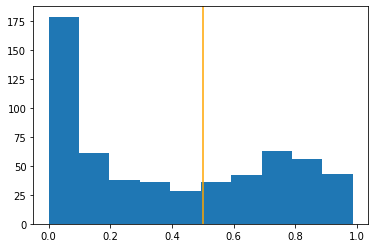

In [273]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [269]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

3
582


In [270]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y_test)

393     1
5091    1
2638    0
1002    0
168     0
5494    1
800     0
1732    1
4532    1
5381    0
1599    0
4037    0
2775    0
4398    1
3968    0
1032    1
5781    0
2705    0
4270    0
156     0
1717    1
1558    0
1393    1
1554    0
3250    0
4969    1
2623    0
4689    1
4985    0
1421    0
4594    0
1741    0
2118    1
2977    0
4454    1
4253    1
3258    0
5606    1
3135    0
1702    0
3276    1
1586    1
2859    0
3686    0
4025    0
308     0
3678    0
2584    0
2098    1
5090    0
4484    0
5589    0
1438    0
5002    0
1694    1
4560    0
4653    0
279     0
4337    0
5141    0
2225    0
4902    0
2924    1
3349    1
3626    0
3978    0
3551    0
2893    0
5680    1
4139    0
4420    1
408     0
1397    0
5485    1
3669    1
2805    0
5367    0
5528    0
4113    0
1101    0
101     0
5333    0
3039    1
4507    1
808     0
626     1
2154    1
3870    0
3340    0
2642    0
2233    1
4259    0
233     1
2380    1
3063    0
4645    0
5099    1
3409    0
2531    0
3698    0


In [271]:
print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)])

        y_hat  y
106  0.089020  1
392  0.005933  1
534  0.092087  1


In [272]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

        y_hat  y
46   0.968227  0
462  0.959825  0
482  0.924885  0
582


In [275]:
print(X_test)

[[ 0  0  0 ... 14 12  4]
 [ 0  0  0 ...  1 25  7]
 [ 0  0  0 ...  2 11 10]
 ...
 [ 0  0  0 ...  2  1  7]
 [ 0  0  0 ...  2  1  7]
 [ 0  0  0 ...  2  8  4]]


In [341]:
test_l = []
num = int(input('Input number of movie: '))
print("This is your movie: ", df['Name of movie'][num],",",df['Genre'][num] )
test_l.extend(df['Name of movie'][num].lower().replace(':','').split(' '))
test_l.extend(df['Genre'][num].replace(' ','').lower().split(','))
#test_l.extend(df['Description'][num].lower().replace(':','').replace('.','').replace(',','').split(' '))
for i in test_l:
  if i in stpwrds:
    test_l.remove(i)
test_l= [stemmer.stem(w) for w in test_l]
print(test_l)

t.fit_on_texts([test_l])
info_sequences = t.texts_to_sequences([test_l])
info_sequences = tf.keras.preprocessing.sequence.pad_sequences(info_sequences, maxlen=maxlen)
info_sequences = np.where(info_sequences > 3049, 0, info_sequences)
print(info_sequences)
y_try = model.predict(info_sequences)
print(y_try)
print(df['Age rate'][num])

Input number of movie: 44
This is your movie:  A Clockwork Orange , Crime, Drama, Sci-Fi            
['clockwork', 'orang', 'crime', 'drama', 'sci-fi']
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 838 532   8
    1  12]]
[[0.81011486]]
R


# Load/Save Model

In [274]:
model.save(output_dir+'/model_v006_2datasets+higher_accuracy')

INFO:tensorflow:Assets written to: model_output/dense/model_v006_2datasets+higher_accuracy/assets
